<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/Jordan/jordan_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The demo_pipeline file we've been working with uses some of the more advanced features of caiman which I think are throwing me off. 

This notebook is intended to implement a more stripped down version of the caiman pipeline with the goal of understanding the functions better and potentially being a platform to write our wrapper around for the parameter gridsearch

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Install CaImAn - takes around 2 minutes
!git clone https://github.com/flatironinstitute/CaImAn.git
%cd '/content/CaImAn/'
!pip install .

# Install caiman dependencies (&> /dev/null will suppress the hundreds of printed lines in the output)
!pip install -r requirements.txt &> /dev/null

#import other dependencies
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt

#IMPORTANT! Newer versions of h5py will cause errors when saving results
!pip install h5py==2.10.0
import h5py

#Set up caiman
!python setup.py build_ext -i

#Other file setup
!python caimanmanager.py install --inplace

#Caiman imports
import caiman as cm
from caiman.paths import caiman_datadir
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.summary_images import local_correlations_movie_offline


Cloning into 'CaImAn'...
remote: Enumerating objects: 24903, done.
remote: Counting objects: 100% (838/838), done.
remote: Compressing objects: 100% (410/410), done.
remote: Total 24903 (delta 470), reused 733 (delta 412), pack-reused 24065
Receiving objects: 100% (24903/24903), 518.50 MiB | 28.35 MiB/s, done.
Resolving deltas: 100% (16683/16683), done.
Checking out files: 100% (317/317), done.
/content/CaImAn
Processing /content/CaImAn
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for caiman: filename=caiman-1.9.6-cp37-cp37m-linux_x86_64.whl size=123929521 sha256=9e2c7af9eb3e1a4e516467cb396917e14bea156eb9c7c3822ce7dd0377eace2

In [8]:
#Using h5py to open and explore a test raw stack
#paths into google drive to a random pre-motion correction movie
stackRaw = h5py.File('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/210815_0/210815_0_1_stackRaw_pmc_mix1_syt_.mat', 'r+')


In [9]:
#save movie array as a variable to check a few frames
mov = np.array(stackRaw['stackRaw_pmc'])

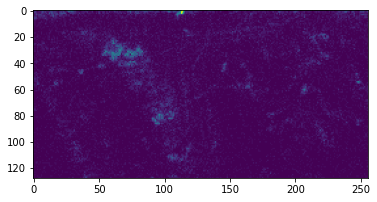

In [10]:
#numpy function to flip the x and y for whole movie array
flip = np.transpose(mov, axes = (0,2,1))
#show the 500th frame
plt.imshow(flip[500])

In [11]:
#save the first 500 frames back to an h5 file to test with
#This is just for development so we don't have to wait for processing times
#h5f = h5py.File('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/subset_stackRaw_pmc.h5', 'w')
#h5f.create_dataset('stackRaw_pmc', data=flip[:500])

#h5f.close()

In [12]:
# start a cluster
c, dview, n_processes =\
    cm.cluster.setup_cluster(backend='local', n_processes=None,
                                 single_thread=False)

In [13]:
#dview.terminate()

In [14]:
#%% First setup some parameters for data and motion correction
# dataset dependent parameters

# ADJUSTED FROM DEFAULTS TO CARL'S PARAMS ON 11/13 (not completely)

fnames = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/210815_0/210815_0_1_stackRaw_pmc_mix1_syt_.mat'] #path to video file
fr = 20             # imaging rate in frames per second
decay_time = 0.4    # length of a typical transient in seconds
dxy = (2., 2.)      # spatial resolution in x and y in (um per pixel)
# note the lower than usual spatial resolution here
max_shift_um = (12., 12.)       # maximum shift in um
patch_motion_um = (100., 100.)  # patch size for non-rigid correction in um

# motion correction parameters
pw_rigid = False       # flag to select rigid vs pw_rigid motion correction
# maximum allowed rigid shift in pixels
max_shifts = [int(a/b) for a, b in zip(max_shift_um, dxy)]
# start a new patch for pw-rigid motion correction every x pixels
strides = tuple([int(a/b) for a, b in zip(patch_motion_um, dxy)])
# overlap between pathes (size of patch in pixels: strides+overlaps)
overlaps = (24, 24)
# maximum deviation allowed for patch with respect to rigid shifts
max_deviation_rigid = 3

opts = params.CNMFParams()

opts.set('motion', {
    'fnames': fnames,
    'fr': fr,
    'decay_time': decay_time,
    'dxy': dxy,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': 'copy'
    #'var_name_hdf5': 'stackRaw_pmc'
})




In [15]:
# set up some parameters for extraction
fnames = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/210815_0/210815_0_1_stackRaw_pmc_mix1_syt_.mat']
                        # file(s) to be analyzed
is_patches = True       # flag for processing in patches or not
fr = 20                 # approximate frame rate of data
decay_time = .4        # length of transient

if is_patches:          # PROCESS IN PATCHES AND THEN COMBINE
    rf = 25             # half size of each patch
    stride = 5          # overlap between patches
    K = 3               # number of components in each patch
else:                   # PROCESS THE WHOLE FOV AT ONCE
    rf = None           # setting these parameters to None
    stride = None       # will run CNMF on the whole FOV
    K = 40              # number of neurons expected (in the whole FOV)

gSig = [6, 6]           # expected half size of neurons
merge_thresh = 0.95     # merging threshold, max correlation allowed
p = 0                   # order of the autoregressive system
gnb = 2                 # global background order

var_name_hdf5 = 'stackRaw_pmc' #variable to path caiman into the subfolder within our mat files

opts.set('data', {'fnames': fnames,
                   'fr': fr,
                   'decay_time': decay_time,
                   'rf': rf,
                   'stride': stride,
                   'K': K,
                   'gSig': gSig,
                   'merge_thr': merge_thresh,
                   'p': p,
                   'nb': gnb
                   #'var_name_hdf5': var_name_hdf5
                  })




In [16]:
# %% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier (this will pick up only neurons
#           and filter out active processes)

min_SNR = 2      # peak SNR for accepted components (if above this, acept)
rval_thr = 0.95     # space correlation threshold (if above this, accept)
use_cnn = True      # use the CNN classifier
min_cnn_thr = 0.90  # if cnn classifier predicts below this value, reject
cnn_lowest = 0.1 # neurons with cnn probability lower than this value are rejected

opts.set('quality', {'min_SNR': min_SNR,
                                'rval_thr': rval_thr,
                                'use_cnn': use_cnn,
                                'min_cnn_thr': min_cnn_thr,
                                'cnn_lowest': cnn_lowest})

#cnm2.estimates.evaluate_components(images, cnm2.params, dview=dview)

In [17]:
#THIS FUCKING LINE IS ALL IT TOOK
#THE MOTION PARAMS DOES NOT PULL IN THE VAR NAME BY DEFAULT
#NEEDS TO BE MANUALLY INJECTED SO IT GETS PULLED INTO MOTION CORRECT WITH THE REST

opts.motion['var_name_hdf5'] = 'stackRaw_pmc'
opts.data['var_name_hdf5'] = 'stackRaw_pmc'

The 2 lines below initiate and then run the caiman motion correction, deconvolution, and ROI evaluation by calling the fit_file function.

Pasting the source code of fit_file here for transparency: 


def fit_file(self, motion_correct=False, indices=None, include_eval=False):

        This method packages the analysis pipeline (motion correction, memory
        mapping, patch based CNMF processing and component evaluation) in a
        single method that can be called on a specific (sequence of) file(s).
        It is assumed that the CNMF object already contains a params object
        where the location of the files and all the relevant parameters have
        been specified. The method will perform the last step, i.e. component
        evaluation, if the flag "include_eval" is set to `True`.

        Args:
            motion_correct (bool)
                flag for performing motion correction
            indices (list of slice objects)
                perform analysis only on a part of the FOV
            include_eval (bool)
                flag for performing component evaluation
        Returns:
            cnmf object with the current estimates


        if indices is None:
            indices = (slice(None), slice(None))
        fnames = self.params.get('data', 'fnames')
        if os.path.exists(fnames[0]):
            _, extension = os.path.splitext(fnames[0])[:2]
            extension = extension.lower()
        else:
            logging.warning("Error: File not found, with file list:\n" + fnames[0])
            raise Exception('File not found!')

        base_name = pathlib.Path(fnames[0]).stem + "_memmap_"
        if extension == '.mmap':
            fname_new = fnames[0]
            Yr, dims, T = mmapping.load_memmap(fnames[0])
            if np.isfortran(Yr):
                raise Exception('The file should be in C order (see save_memmap function)')
        else:
            if motion_correct:
                mc = MotionCorrect(fnames, dview=self.dview, **self.params.motion)
                mc.motion_correct(save_movie=True)
                fname_mc = mc.fname_tot_els if self.params.motion['pw_rigid'] else mc.fname_tot_rig
                if self.params.get('motion', 'pw_rigid'):
                    b0 = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                            np.max(np.abs(mc.y_shifts_els)))).astype(np.int)
                    self.estimates.shifts = [mc.x_shifts_els, mc.y_shifts_els]
                else:
                    b0 = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)
                    self.estimates.shifts = mc.shifts_rig
                # TODO - b0 is currently direction inspecific, which can cause
                # sub-optimal behavior. See
                # https://github.com/flatironinstitute/CaImAn/pull/618#discussion_r313960370
                # for further details.
                # b0 = 0 if self.params.get('motion', 'border_nan') is 'copy' else 0
                b0 = 0
                fname_new = mmapping.save_memmap(fname_mc, base_name=base_name, order='C',
                                                 border_to_0=b0)
            else:
                fname_new = mmapping.save_memmap(fnames, base_name=base_name, order='C')
            Yr, dims, T = mmapping.load_memmap(fname_new)

        images = np.reshape(Yr.T, [T] + list(dims), order='F')
        self.mmap_file = fname_new
        if not include_eval:
            return self.fit(images, indices=indices)

        fit_cnm = self.fit(images, indices=indices)
        Cn = summary_images.local_correlations(images[::max(T//1000, 1)], swap_dim=False)
        Cn[np.isnan(Cn)] = 0
        fit_cnm.save(fname_new[:-5]+'_init.hdf5')
        #fit_cnm.params.change_params({'p': self.params.get('preprocess', 'p')})
        # RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution
        cnm2 = fit_cnm.refit(images, dview=self.dview)
        cnm2.estimates.evaluate_components(images, cnm2.params, dview=self.dview)
        # update object with selected components
        #cnm2.estimates.select_components(use_object=True)
        # Extract DF/F values
        cnm2.estimates.detrend_df_f(quantileMin=8, frames_window=250)
        cnm2.estimates.Cn = Cn
        cnm2.save(cnm2.mmap_file[:-4] + 'hdf5')

        cluster.stop_server(dview=self.dview)
        log_files = glob.glob('*_LOG_*')
        for log_file in log_files:
            os.remove(log_file)

        return cnm2


In [18]:
# %% Now RUN CaImAn Batch (CNMF)
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
cnm = cnm.fit_file(motion_correct = True, include_eval=True)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


USING MODEL:/root/caiman_data/model/cnn_model.json
1/1 [==============================] - 1s 576ms/step


These cells only work if the fit function has gone through without errors

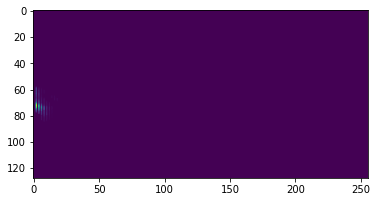

In [19]:
import matplotlib.pyplot as plt
dims = [128, 256]
#5th component
plt.figure() 
plt.imshow(np.reshape(cnm.estimates.A[:,4].toarray(), dims, order='F'))

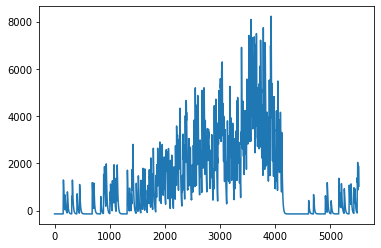

In [20]:
#deconvolved trace for 5th component
plt.figure() 
plt.plot(cnm.estimates.C[4])

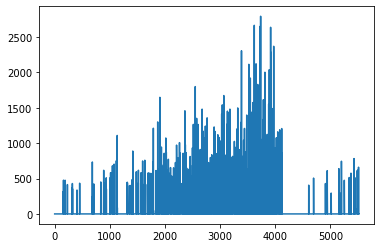

In [21]:
#inferred spikes for 5th component
plt.figure() 
plt.plot(cnm.estimates.S[4])

In [22]:
#returns a list of our binary masks
M = cnm.estimates.A > 0
masks = [np.reshape(M[:,i].toarray(), dims, order='F') for i in range(M.shape[1])]

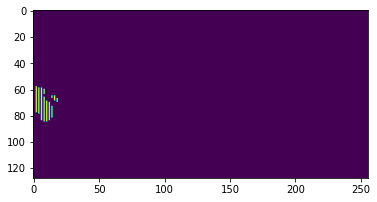

In [23]:
#plot mask for 3rd ROI
plt.imshow(np.reshape(masks[4], dims, order='F'))

In [24]:
M.shape

(32768, 28)

In [25]:
# %% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)

In [27]:
np.shape(cnm.estimates)

()

In [34]:
f2 = h5py.File('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat', 'r+')

In [41]:
f2

<HDF5 file "210728_0_1_manualROIs_tm2_tm9_syt.mat" (mode r+)>

In [45]:
list(f2.keys())

['bwLabel']

In [47]:
data = f2['bwLabel']

In [49]:
data.shape

(256, 128)

In [57]:
data = data[:] #converts to an array (places the data in memory, otherwise just an HDF5 object that can only be sliced)

In [56]:
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [90]:
data1 = np.empty((0,128))
data2 = np.empty((0,128))

for i in data:
  data1 = np.append(data1,np.array([[x if x==1 else 0 for x in i]]), axis=0)
  data2 = np.append(data2,np.array([[x if x==2 else 0 for x in i]]), axis=0)

np.shape(data1)

(256, 128)

In [91]:
# make sure it works
counter = 0
for x in data2:
  for y in x:
    if y == 2:
      counter += 1
counter

78

In [92]:
counter = 0
for x in data:
  for y in x:
    if y == 2:
      counter += 1
counter
# works!!

78

In [93]:
with h5py.File('test.hdf5', 'w') as f:
    f.create_dataset('ds_1', data = data1)
    f.create_dataset('ds_2', data = data2)

In [ ]:
#Using h5py to pull back in and see the saved output
import h5py
f = h5py.File(cnm.mmap_file[:-5]+'_init.hdf5', 'r')


In [ ]:
#This shape should match matrix A from the cnm object above, but doesn't
f['estimates']['A']['data']

<HDF5 dataset "data": shape (9643,), type "<f4">

In [ ]:
!ls ../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210815_0_1_manualROIs_mix1_syt.mat

#stackRaw/210815_0/210815_0_1_stackRaw_pmc_mix1_syt_.mat'

../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210815_0_1_manualROIs_mix1_syt.mat


In [ ]:
#moving on to reading roi masks attempting to compare to matrix A from cnm object
f = h5py.File('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210815_0_1_manualROIs_mix1_syt.mat', 'r')

f.keys()


<KeysViewHDF5 ['bwLabel']>

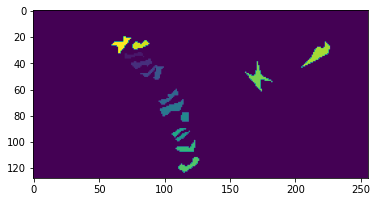

In [ ]:
plt.imshow(np.array(f['bwLabel']).T)

In [ ]:
#moving on to reading roi masks attempting to compare to matrix A from cnm object
f = h5py.File('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210731_0_1_manualROIs_t5_syt.mat', 'r')

f.keys()


<KeysViewHDF5 ['bwLabel']>

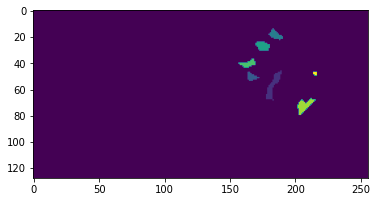

In [ ]:
plt.imshow(np.array(f['bwLabel']).T)